# Generating Experimental PDF

## Theory of Electron Scattering

See [Centurion et al](https://www.annualreviews.org/doi/abs/10.1146/annurev-physchem-082720-010539) for a full discription of the theory. 

Electrons being scattered by an arbitrary electric field, $V(\vec{r})$, can be described using the Born approximation to the Schrodinger equation via: 

\begin{equation}
\tag{1}
f(\vec{s}) = {m \over 2 \pi \hbar^{2}} \int exp(-i \vec{s} \cdot \vec{r'}) V(\vec{r'}) d^{3} r' \label{eq1}
\end{equation}

where $\vec{s}$ is the momentum transfer of the scattered electron with mass $m$. In MeV-UED experiments, the dominant electron-matter interaction is Coulombic, thus it is possible to represent the scattered wave function by a Fourier transform of the Coulombic potential field. 

\begin{equation}
\tag{2}
f(\vec{s}) = {m e \over 2 \pi \varepsilon_0 \hbar} {1 \over 2} \int exp(-i \vec{s} \cdot \vec{r}) \rho (\vec{r}) d^{3} r \label{eq2}
\end{equation} 

Here, $\rho(\vec{r})$ is the charge distribution of the sample and $s^{-2}$ is a prefactor. Equation 2 shows that the amplitude of the elastic scattering is proportional to the Fourier transform of $\rho(\vec{r})$.

The charge density of the nucleus and the electron of an atom with an atomic number $Z$ can be given by 

\begin{equation}
\tag{3}
\rho(r) = Ze\delta(\vec{r}) + \rho_{e}(r)
\end{equation} 

where $r$ is the radial dimension in spherical coordinates. In combination with the atomic form factor equation of X-ray scattering, $F(s)$

\begin{equation}
\tag{4}
F(s) = 4\pi \int \rho_{e}(r) {\sin (sr) \over sr} r^{2} dr
\end{equation} 

equation 2 can be rewritten as 

\begin{equation} 
\tag{5}
f(s) = {me^{2} \over 2 \pi \varepsilon_{0} \hbar^{2}} {1 \over 2} \lbrack Z-F(s) \rbrack
\end{equation} 

Assuming the independent atom model (IAM), the elastic scattering of a molecule made of $N$ atoms is defined as 

\begin{equation}
\tag{6}
f_{M}(\vec{s}) = \sum_{i=1}^{N} f_{i} (s) e^{i\vec{s} \cdot \vec{r_{i}}}
\end{equation}

where $f_{i}(s)$ is the atomic form factor of the atom as given by Equation 5 and $\vec{r_{i}}$ is the position of vector of the atom. 

Following this, the total scattering of the molecule $I(s)$ of randomly oriented molecules can be found by 

\begin{equation}
\tag{7}
I(s) = I_{at} + I_{mol} = \sum_{i=1}^{N} |f_{i}(s)|^{2} + \sum_{i=1}^{N} \sum_{j=1, j \neq i}^{N} f_{i}^{\ast}(s) f_{j}(s) { \sin (s r_{ij}) \over s r_{ij}}
\end{equation}

Equation 7 gives the result of the IAM of a rigid molecule of an randomly oriented ensemble. See Centurion et al for additional corrections to Equation 7. 

When processing MeV-UED data, the scattering signal is best represented by 

\begin{equation}
\tag{8}
sM(s) = s {I_{mol} \over I_{at}}
\end{equation} 

The real-space pair distribution function (PDF) is found to be proportional to the probability of finding an atom pair at a distance $r$. This probability is given by

\begin{equation} 
\tag{9}
P(r) = r \int_{0}^{\infty} sM(s) \sin{sr} ds \approx r \int_{s_{min}}^{s_{max}} sM(s) \sin(sr) e^{-\alpha s^{2}} ds
\end{equation} 

As no experiment can measure out to an infinite $s$ value, the above approximation is applied where $e^{-\alpha s^{2}}$ is a damping factor. The following code produces simulated scattering patters based on computed xyz coordinates of a given molecule. 

## Import Necessary Function

In [164]:
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import sys
sys.path.append('packages')
import warnings
import random as rdm
from tqdm import tqdm
from scipy import signal
import scipy.interpolate as interp
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit
import scipy.stats
from PIL import Image
import cv2 as cv
from matplotlib.colors import TwoSlopeNorm
from scipy.ndimage import gaussian_filter1d
warnings.simplefilter("ignore")


## Define Functions

### Getting Diffraction Scattering Signals

In [165]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

path_dcs= '/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/packages/dcs_repository/3.7MeV/'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/'
table=pd.read_csv(path_dcs+'Periodic_Table.csv')
def import_s():
    """ This functions uses the C.dat files as an example file to generate values of s for the simulation calculations. 
    
    RETURNS:
    s (array) = array of s values which correspond to calculated scattering intensities for each atom.
    """
    
    qe=1.602176565e-19 
    me=9.10938291e-31
    c=299792458 
    h=6.62606957e-34
    E=3700000*qe+me*c**2 #kinetic energy=3.7MeV
    p=(E**2/c**2-me**2*c**2)**0.5
    lamb=h/p
    k=2*np.pi/lamb #wave vector of the incident electron

    path=path_dcs+'C.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    theta_deg=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        theta_deg[i]=a31[2]
    
    theta=theta_deg*np.pi/180
    S=2*k*np.sin(0.5*theta)
    s=np.array(S)
    return s

def read_dat_dcs(atom_no,path_dcs):
    """ Reads in the scattering intensity (form factors) for each atom in the molecule of interest from the .dat files calculated using ELSEPA. 
    
    ARGUMENTS: 
    atom_no (int) = maximum atomic number of interest (default value is 55)
    path_dcs (string) = path to the folder containing the .dat files
    
    RETURNS:
    data (array) = values of the scattering intensities in cm taken from the .dat files. 
    """
    
    atom_sym=no_to_sym(atom_no)
    path=path_dcs+atom_sym+'.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    data=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        #print(a31)
        data[i]=a31[6]
    #print(data)
    return data**0.5 ## returns in cm

def sym_to_no(atom_symbol):
    """ Short cut for getting the atomic number from the atomic symbol.
    
    ARGUMENTS: 
    atom_symbol (string) = atomic symbol
    
    RETURNS:
    atom_number (int) = atomic number
    """
    
    n=np.where(table['Symbol']==atom_symbol)
    atom_number = int(n[0]+1)
    return atom_number

def no_to_sym(atom_number):
    """ Short cut for getting the atomic symbol from the atomic number. 
    
    ARGUMENTS: 
    atom_number (int) = atomic number
    
    RETURNS:
    atom_symbol (string) = atomic symbol    
    """
    
    atom_symbol = table['Symbol'][atom_number-1]
    return atom_symbol

def import_DCS(max_at_no=55):
    """ Uses read_dat_dcs to get the form factors for all the atoms available. 
    
    ARGUMENTS: 
    max_at_no (int) = maximum atomic number of interest (default value is 55)
    
    RETURNS:
    f (array) = form factors for all atoms
    """
    
    f=np.empty((max_at_no+1,130))
    for i in range(max_at_no):
        f[i+1]=read_dat_dcs(i+1,path_dcs)
    return f

### Loading in Structures

In [166]:
def load_static_mol_coor(path_mol, mol_name, file_type):
    """ Reads in either a .csv or .xyz file containing moleculear coordinates and adds a column containing the atomic number for each atom in 
    the molecule. Errors are thrown if an improper file type is chosen or if the .xyz or .csv file needs further formatting.
    
    ARGUMENTS:
    
    path_mol (string) = path to the directory of the molecular structure
    mol_name (string) = file name of the structural file used for the simulation
    file_type (string) = either xyz or csv depending on what the file being used is. Determines treatment
    
    RETURNS:
    
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    atom_sum (int) = total number of atoms in the molecule
    """
    
    filename=path_mol + mol_name + file_type
    if file_type=='.xyz':
        [coor_xyz,atom_sum]=load_xyz_new(filename)
        coor=get_modified_coor_for_xyz(coor_xyz,atom_sum)
        
    if file_type=='.csv':
        mol_filename=mol_name+'.csv'
        coor_M=pd.read_csv(path_mol+mol_filename)
        coor=np.array(coor_M)
        num=np.array(coor[:,3])
        atom_sum=int(len(num))
        coor=get_modified_coor_for_csv(coor,atom_sum)

    elif file_type!='.csv' and file_type!='.xyz':
        print('error! Please type in the right molecular coordinate file type, .xyz or .csv')
        
    return coor,atom_sum


def load_xyz_new(xyz_file):
    """Reads in an .xyz generated from programs such as Gaussian or ORCA.
    
    ARGUMENTS: 
    xyz_file (string) = full path to the .xyz file of interest.
    
    RETURNS: 
    re (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x, y, z 
        coordinates
    atom_sum (int) = total number of atoms in the molecule
    """

    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    count = len(text)
    re = []
    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            re.append(string)
        except Exception:
            pass    
    atom_sum = re[0]
    atom_sum = int(np.array(atom_sum))
    re = np.array(re[2:])
    return re, atom_sum
    

def get_modified_coor_for_xyz(re,atom_sum):
    """ Appends a column of atomic numbers to the coordinate array read from the .xyz file
    
    ARGUMENTS: 
    re (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x, y, z 
        coordinates
    atom_sum (int) = total number of atoms in the molecule
    
    RETURNS: 
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    """
    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(re[i][0])

    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((re,atom_num))

    return coor

def get_modified_coor_for_csv(coor_csv,atom_sum):
    """ Appends a column of atomic numbers to the coordinate array read from the .csv file
    
    ARGUMENTS: 
    coor_csv (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x,
        y, and z coordinates
    atom_sum (int) = total number of atoms in the molecule
    
    RETURNS: 
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    """

    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(coor_csv[i,0])
            
    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((coor_csv,atom_num))

    return coor

### Calculating IAM Pattern

In [167]:
def get_I_atomic(f,s000, s_max, coor, atom_sum):
    I_at_all = []
    s000 = s000*1e-10 #in angstroms
    s_new = np.linspace(0, s_max, 500)
    for i in range(atom_sum):
        I_atomic = []
        I_at = 0
        amps = f[int(coor[i,4])]
        #print(amps)
        interp_amps = interp.interp1d(s000[0:125], amps[0:125])
        amps_new = interp_amps(s_new)
        for k in range(len(amps_new)):
            f_new = amps_new[k]
            I_at = np.abs(f_new)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    I_at = sum(np.array(I_at_all))
    return I_at, s_new

def get_I_molecular(f, s000, s_max, coor, atom_sum):
    x = np.array(coor[:, 1])
    y = np.array(coor[:, 2])
    z = np.array(coor[:, 3])
    
    s000 = s000 * 1e-10 #convert to angstroms
    
    s_new = np.linspace(0, s_max, 500)
    I_mol = np.zeros(len(s_new))
    for i in range(atom_sum):
        for j in range(atom_sum): # Does each atom pair calculation twice
            if i != j:
                r_ij = (float(x[i]) - float(x[j])) ** 2 + (float(y[i]) - float(y[j])) ** 2 + (float(z[i]) - float(z[j])) ** 2
                r_ij = r_ij ** 0.5
                #print(f"bond length between {coor[i, 0]} and {coor[j, 0]} = {r_ij}")
                amps_i = f[int(coor[i,4])]
                amps_j = f[int(coor[j,4])]
                interp_amps_i = interp.interp1d(s000[0:125], amps_i[0:125])
                interp_amps_j = interp.interp1d(s000[0:125], amps_j[0:125])
                amps_new_i = interp_amps_i(s_new)
                amps_new_j = interp_amps_j(s_new)
                #print(len(amps_new_j))
                I_mol[0]+=f[int(coor[i,4]),0]*f[int(coor[j,4]),0]
                I_mol[1:len(s_new)]+=amps_new_i[1:len(s_new)]*amps_new_j[1:len(s_new)]*np.sin(s_new[1:len(s_new)]*r_ij)/s_new[1:len(s_new)]/r_ij
    return I_mol, s_new

def get_I_from_xyz(f, s000, s_max, coor, atom_sum):
    """USE THIS ONE. OLD ONE INTERPOLATES INCORRECTLY"""
    
    I_at, s_new = get_I_atomic(f, s000, s_max, coor, atom_sum)
    I_mol, _ = get_I_molecular(f, s000, s_max, coor, atom_sum)
    I = I_at + I_mol
    return I, I_at, I_mol, s_new



def get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const):
    sM=I_mol/I_at*s #calculate sM from I
    r_max = r_max * 1; # convert to picometer
    r=range(r_max)
    #print(r)
    PDF=[0 for i in range(r_max)]
    for i in range(len(s)-1): 
        PDF+=sM[i]*np.sin(s[i]*1e10*np.array(r)*1e-12)*(s[i+1]-s[i])*np.exp(-s[i]**2/damp_const)
    #for i in range(r_max):
     #   PDF[i]+=sum(sM*np.sin(s*1e10*np.array(r[i])*1e-12)*(s[1]-s[0])*np.exp(-s**2/damp_const))
    return sM,PDF,np.array(r)


def plot_I_sM_PDF(I,sM,PDF,s,r,title_I,title_sM,title_PDF):
    plt.figure()
    plt.subplot(1,3,1)
    plt.plot(s,I/I.max())
    plt.xlabel('s/angs^-1')
    plt.title(title_I)
    plt.grid()
    
    plt.subplot(1,3,2)    
    plt.plot(s,sM)
    plt.xlabel('s/angs^-1')
    plt.title(title_sM)
    plt.grid()
    
    plt.subplot(1,3,3)    
    plt.plot(r,PDF)
    plt.xlabel('r/pm')
    plt.title(title_PDF)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return


### Data Processing

In [168]:
def power_fit(data_array, x_vals, return_baseline=False):
    if len(data_array.shape) == 2:
        baseline2d = []
        for i in range(len(data_array)):
            temp_data = np.copy(data_array[i])
            idx_nan = ~np.isnan(temp_data)
            coeff = np.polyfit(x_vals[idx_nan],temp_data[idx_nan],2)
            baseline = np.polyval(coeff,x_vals)
            baseline2d.append(baseline)

        baseline2d = np.array(baseline2d)
        corrected_data = data_array - baseline2d
        
    elif len(data_array.shape) == 1:
        temp_data = data_array
        idx_nan = ~ np.isnan(temp_data)
        coeff = np.polyfit(x_vals[idx_nan], temp_data[idx_nan], 2)
        baseline2d = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline2d
    else:
        print("Data Array must be 1D or 2D array")
    if return_baseline == True:
        return corrected_data, baseline2d
    else:
        return corrected_data
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data

## Simulate Static Diffraction

In [169]:
angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/'; # The molecular .xyz/.csv pathes
# path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/';
mol_name='o-ntph_opt';
file_type='.xyz'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f=import_DCS(55)
s000=import_s()
s_max = 12 # Max Q range
r_max = 800  # Max R range
damp_const=33

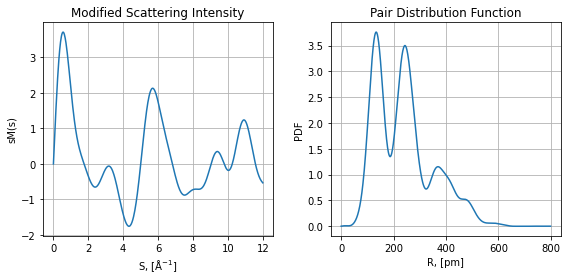

In [170]:
[coor,atom_sum]  = load_static_mol_coor(path_mol,mol_name,file_type);
[I_new,I_at_new,I_mol_new,s_new] = get_I_from_xyz(f,s000,s_max,coor,atom_sum);
[sM_new,PDF_new,r_new]       = get_sM_and_PDF_from_I(I_at_new,I_mol_new,s_new,r_max,damp_const)
# plot_I_sM_PDF(I,sM,PDF,s,r,mol_name+' I elastic',mol_name+' sM',mol_name+' PDF'); # use or not using plot-function 
plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s_new,sM_new);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');plt.title('Modified Scattering Intensity');plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r_new,PDF_new);
plt.xlabel(r'R, [pm]');
plt.ylabel('PDF');
plt.title('Pair Distribution Function');
plt.grid()
    
plt.tight_layout()
plt.show()

## Trying to get PDF...

### Get EXP data and combine

#### __s1__ Load data

In [8]:
day = datetime.date.today()
day = "2023-12-28"
print(day)

2023-12-28


In [91]:
dI_1 = np.loadtxt(f"data_files/dI_corrected_s1_0-500_{day}.txt")
s_1 = np.loadtxt(f"data_files/s_s1_0-500_{day}.txt")
t_1 = np.loadtxt(f"data_files/realtime_s1_0-500_{day}.txt")
stage_1 = np.loadtxt(f"data_files/stage_s1_0-500_{day}.txt")
norm_data_1 = np.loadtxt(f"data_files/norm_data_s1_0-500_{day}.txt")
norm_ref_1 = np.loadtxt(f"data_files/norm_ref_s1_0-500_{day}.txt")

dI_2 = np.loadtxt(f"data_files/dI_corrected_s1_500-1000_{day}.txt")
s_2 = np.loadtxt(f"data_files/s_s1_500-1000_{day}.txt")
t_2 = np.loadtxt(f"data_files/realtime_s1_500-1000_{day}.txt")
stage_2 = np.loadtxt(f"data_files/stage_s1_500-1000_{day}.txt")
norm_data_2 = np.loadtxt(f"data_files/norm_data_s1_500-1000_{day}.txt")
norm_ref_2 = np.loadtxt(f"data_files/norm_ref_s1_500-1000_{day}.txt")

dI_3 = np.loadtxt(f"data_files/dI_corrected_s1_1000-1500_{day}.txt")
s_3 = np.loadtxt(f"data_files/s_s1_1000-1500_{day}.txt")
t_3 = np.loadtxt(f"data_files/realtime_s1_1000-1500_{day}.txt")
stage_3 = np.loadtxt(f"data_files/stage_s1_1000-1500_{day}.txt")
norm_data_3 = np.loadtxt(f"data_files/norm_data_s1_1000-1500_{day}.txt")
norm_ref_3 = np.loadtxt(f"data_files/norm_ref_s1_1000-1500_{day}.txt")

dI_4 = np.loadtxt(f"data_files/dI_corrected_s1_1500-1990_{day}.txt")
s_4 = np.loadtxt(f"data_files/s_s1_1500-1990_{day}.txt")
t_4 = np.loadtxt(f"data_files/realtime_s1_1500-1990_{day}.txt")
stage_4 = np.loadtxt(f"data_files/stage_s1_1500-1990_{day}.txt")
norm_data_4 = np.loadtxt(f"data_files/norm_data_s1_1500-1990_{day}.txt")
norm_ref_4 = np.loadtxt(f"data_files/norm_ref_s1_1500-1990_{day}.txt")

In [92]:
print(norm_data_1.shape)
print(norm_data_2.shape)
print(norm_data_3.shape)
print(norm_data_4.shape)

(37, 463)
(37, 463)
(37, 464)
(37, 463)


In [93]:
# dI_1 = dI_1.T
# dI_1 = dI_1[:451]
# dI_1 = dI_1.T

# dI_2 = dI_2.T
# dI_2 = dI_2[:451]
# dI_2 = dI_2.T

dI_3 = dI_3.T
dI_3 = dI_3[:463]
dI_3 = dI_3.T

norm_data_3 = norm_data_3.T
norm_data_3 = norm_data_3[:463]
norm_data_3 = norm_data_3.T

norm_ref_3 = norm_ref_3.T
norm_ref_3 = norm_ref_3[:463]
norm_ref_3 = norm_ref_3.T

# dI_4 = dI_4.T
# dI_4 = dI_4[:451]
# dI_4 = dI_4.T

__s4__

In [8]:
day = datetime.date.today()
day = "2023-12-28"
print(day)

2023-12-28


In [113]:
dI_1 = np.loadtxt(f"data_files/dI_corrected_s4_0-1000_{day}.txt")
s_1 = np.loadtxt(f"data_files/s_s4_0-1000_{day}.txt")
t_1 = np.loadtxt(f"data_files/realtime_s4_0-1000_{day}.txt")
stage_1 = np.loadtxt(f"data_files/stage_s4_0-1000_{day}.txt")
norm_data_1 = np.loadtxt(f"data_files/norm_data_s4_0-1000_{day}.txt")
norm_ref_1 = np.loadtxt(f"data_files/norm_ref_s4_0-1000_{day}.txt")

dI_2 = np.loadtxt(f"data_files/dI_corrected_s4_1000-2000_{day}.txt")
s_2 = np.loadtxt(f"data_files/s_s4_1000-2000_{day}.txt")
t_2 = np.loadtxt(f"data_files/realtime_s4_1000-2000_{day}.txt")
stage_2 = np.loadtxt(f"data_files/stage_s4_1000-2000_{day}.txt")
norm_data_2 = np.loadtxt(f"data_files/norm_data_s4_1000-2000_{day}.txt")
norm_ref_2 = np.loadtxt(f"data_files/norm_ref_s4_1000-2000_{day}.txt")

dI_3 = np.loadtxt(f"data_files/dI_corrected_s4_2000-3000_{day}.txt")
s_3 = np.loadtxt(f"data_files/s_s4_2000-3000_{day}.txt")
t_3 = np.loadtxt(f"data_files/realtime_s4_2000-3000_{day}.txt")
stage_3 = np.loadtxt(f"data_files/stage_s4_2000-3000_{day}.txt")
norm_data_3 = np.loadtxt(f"data_files/norm_data_s4_2000-3000_{day}.txt")
norm_ref_3 = np.loadtxt(f"data_files/norm_ref_s4_2000-3000_{day}.txt")

dI_4 = np.loadtxt(f"data_files/dI_corrected_s4_3000-4000_{day}.txt")
s_4 = np.loadtxt(f"data_files/s_s4_3000-4000_{day}.txt")
t_4 = np.loadtxt(f"data_files/realtime_s4_3000-4000_{day}.txt")
stage_4 = np.loadtxt(f"data_files/stage_s4_3000-4000_{day}.txt")
norm_data_4 = np.loadtxt(f"data_files/norm_data_s4_3000-4000_{day}.txt")
norm_ref_4 = np.loadtxt(f"data_files/norm_ref_s4_3000-4000_{day}.txt")

In [114]:
print(dI_1.shape)
print(dI_2.shape)
print(dI_3.shape)
print(dI_4.shape)

(37, 452)
(37, 453)
(37, 451)
(37, 451)


In [115]:
dI_1 = dI_1.T
dI_1 = dI_1[:451]
dI_1 = dI_1.T

norm_data_1 = norm_data_1.T
norm_data_1 = norm_data_1[:451]
norm_data_1 = norm_data_1.T

norm_ref_1 = norm_ref_1.T
norm_ref_1 = norm_ref_1[:451]
norm_ref_1 = norm_ref_1.T

dI_2 = dI_2.T
dI_2 = dI_2[:451]
dI_2 = dI_2.T

norm_data_2 = norm_data_2.T
norm_data_2 = norm_data_2[:451]
norm_data_2 = norm_data_2.T

norm_ref_2 = norm_ref_2.T
norm_ref_2 = norm_ref_2[:451]
norm_ref_2 = norm_ref_2.T

# dI_3 = dI_3.T
# dI_3 = dI_3[:463]
# dI_3 = dI_3.T

# dI_4 = dI_4.T
# dI_4 = dI_4[:451]
# dI_4 = dI_4.T

#### Set up Data

In [116]:
stage_temp = np.concatenate((stage_4, stage_3, stage_2, stage_1), axis=0) 
print(stage_temp)
s_temp = np.concatenate((s_4, s_3, s_2, s_1), axis=0)
dI_temp = np.concatenate((dI_4, dI_3, dI_2, dI_1), axis=0)
norm_data_temp = np.concatenate((norm_data_4, norm_data_3, norm_data_2, norm_data_1), axis=0)
#norm_ref_temp = np.concatenate((norm_ref_4, norm_ref_3, norm_ref_2, norm_ref_1), axis=0)
#print(np.where(stage_temp==108.)[0])

[153.    153.01  154.345 154.355 154.365 154.375 154.385 154.395 154.405
 154.415 154.425 154.435 154.445 154.455 154.465 154.475 154.485 154.495
 154.505 154.515 154.525 154.535 154.545 154.555 154.565 154.6   154.63
 154.66  154.69  154.72  154.795 154.945 155.095 155.245 156.    157.5
 162.    153.    153.01  154.345 154.355 154.365 154.375 154.385 154.395
 154.405 154.415 154.425 154.435 154.445 154.455 154.465 154.475 154.485
 154.495 154.505 154.515 154.525 154.535 154.545 154.555 154.565 154.6
 154.63  154.66  154.69  154.72  154.795 154.945 155.095 155.245 156.
 157.5   162.    153.    153.01  154.345 154.355 154.365 154.375 154.385
 154.395 154.405 154.415 154.425 154.435 154.445 154.455 154.465 154.475
 154.485 154.495 154.505 154.515 154.525 154.535 154.545 154.555 154.565
 154.6   154.63  154.66  154.69  154.72  154.795 154.945 155.095 155.245
 156.    157.5   162.    153.    153.01  154.345 154.355 154.365 154.375
 154.385 154.395 154.405 154.415 154.425 154.435 154.445 15

In [117]:
uni_stage = np.round(np.unique(stage_temp), decimals=3)
stage_temp = stage_temp.round(decimals=3)
print(uni_stage.shape)

(37,)


In [118]:
%%time
stage_len = len(uni_stage);               #  Number of delays
norm_data = []
norm_ref = []
ave_data = []

for i in range(stage_len):
    #print(uni_stage[i])
    data = norm_data_temp[np.where(stage_temp==uni_stage[i])[0]];
    dI = dI_temp[np.where(stage_temp==uni_stage[i])[0]];
    
    data_ave = np.nanmean(data,axis=0);
    dI_ave = np.nanmean(dI, axis=0)
    
    norm_data.append(data_ave)
    ave_data.append(dI_ave)

norm_data = np.array(norm_data)
norm_ref = np.array(np.nanmean((norm_ref_1, norm_ref_2, norm_ref_3, norm_ref_4), axis=0))
ave_data = np.array(ave_data)

CPU times: user 3.64 ms, sys: 242 µs, total: 3.88 ms
Wall time: 3.35 ms


#### Plot Data

37
127


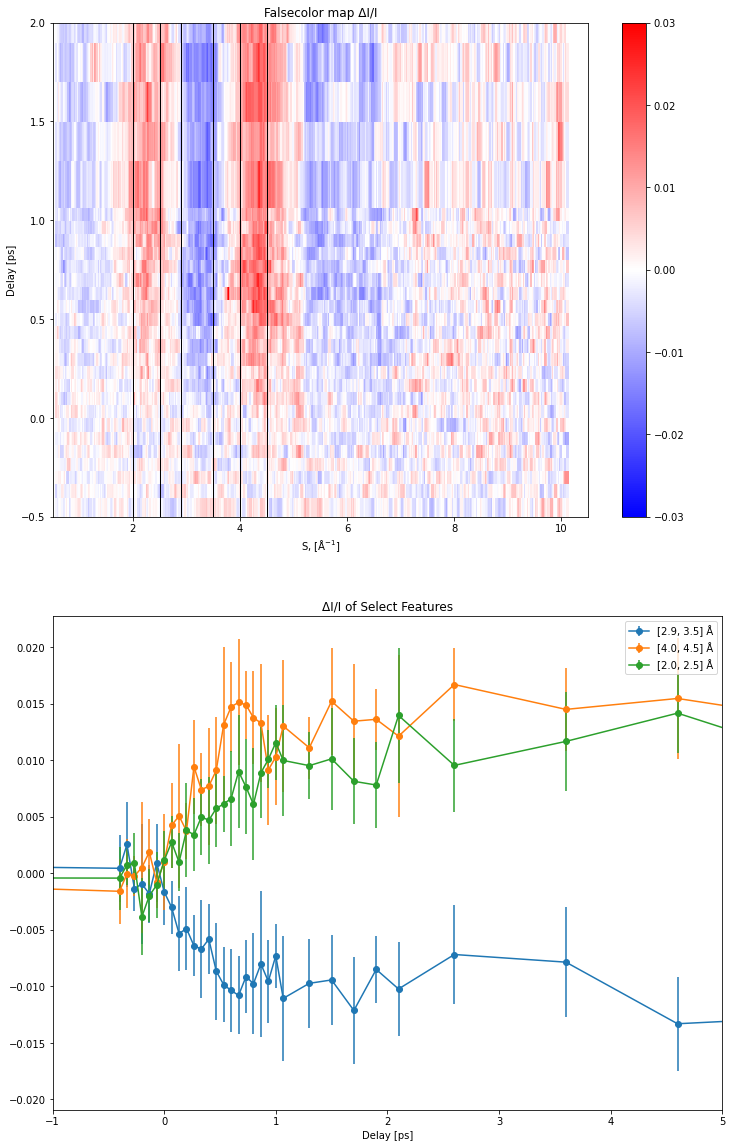

In [120]:
angs = '\u00C5';

#posi_0 = 108.63
posi_0 = 154.405
uni_time = (uni_stage - posi_0)/0.15
print(len(uni_time))

s_cali = 0.0228
RoI_1 = [2.9, 3.5];
RoI_2 = [4.0, 4.5];
RoI_3 = [2.0, 2.5];


print(round(RoI_1[0]/s_cali))
Inte_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s_4,uni_time,ave_data,cmap='bwr');
plt.clim(vmin=-0.03, vmax=0.03);
plt.colorbar()
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.ylim(-0.5, 2)
plt.xlim(0.5,10.5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)
plt.errorbar(uni_time,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(uni_time,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.errorbar(uni_time, Inte_3, yerr = std_3, fmt='-o', label=str(RoI_3)+' '+angs)
plt.xlim(-1, 5)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

In [173]:
def correct_offset(dI, x=300):
    #dI = (I_norm - I_ref)
    corrected = []
    for i in range(len(dI)):
        ends = np.nanmean(dI[i][x:])
        correct = dI[i]- ends
        corrected.append(correct)
        
    corrected = np.array(corrected)
    plt.figure()
    plt.plot(dI[-1][300:], label = "original")
    plt.plot(corrected[-1][300:], label="corrected")
    plt.legend()
    plt.title("Corrected data")
    plt.show()
    return corrected



def get_sM(f, s000, s_exp, coor, atom_sum, dI):
    I_at_all = []
    s000 = s000*1e-10
    for i in range(atom_sum):
        I_atomic = []
        I_at = 0
        amps = f[int(coor[i,4])]
        #print(amps)
        interp_amps = interp.interp1d(s000[0:125], amps[0:125])
        amps_new = interp_amps(s_exp)
        for k in range(len(amps_new)):
            f_new = amps_new[k]
            I_at = np.abs(f_new)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    I_at = sum(np.array(I_at_all))
    
    sM_new = []              
    for i in range(len(dI)):
        sM_temp = s_exp*(dI[i])/I_at
        temp_mean = np.mean(sM_temp[25:30])
        #print(temp_mean)
        slope = temp_mean/25
        sM_temp[0:25] = np.arange(0,25)*slope
        sM_new.append(sM_temp)
    
    sM = np.array(sM_new)/np.max(np.array(sM_new))
    return(sM)


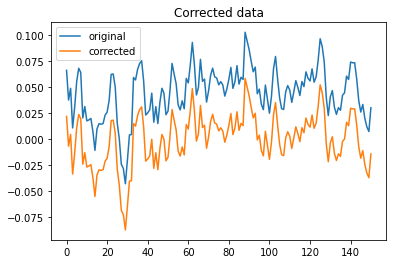

(37, 451)


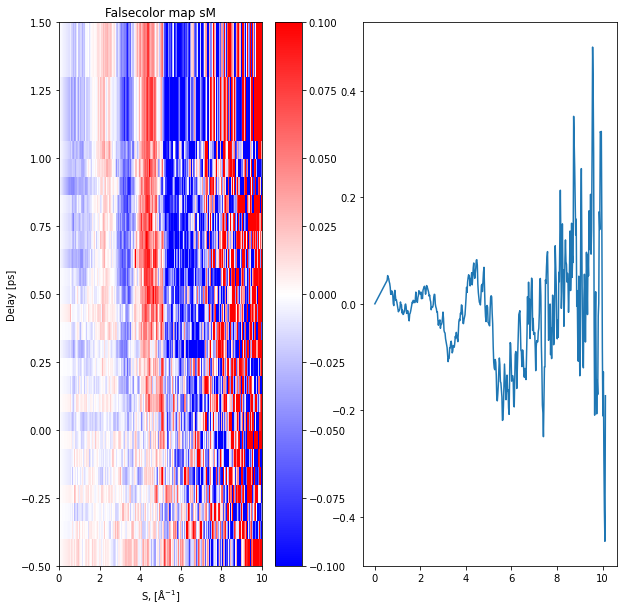

In [181]:
dI = (norm_data - norm_ref)
dI_fit = power_fit(dI, s_3)
dI_corrected = correct_offset(dI)

sM = get_sM(f, s000, s_3, coor, atom_sum, dI_corrected)
print(sM.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolor(s_3, t_1, sM,cmap='bwr')
plt.clim(vmin=-0.1, vmax=0.1);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlim(0, 10)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map sM')

plt.subplot(1,2,2)
plt.plot(s_3, sM[-1])
plt.show()

In [182]:
def get_exp_PDF(sM, s_exp, r_max):
    smax=np.max(s_exp);
    s1=len(sM);
    ds=0.0228; # step size of s 
    print(ds)
    rmax=10; # in angstroms
    r=np.linspace(0,rmax,np.round(1000));

    pdf_exp = []
    for i in range(len(sM)):
        sM_new=sM[i]*np.exp(-ds*(s_exp**2));
        #print(len(sM_new))
        fr_temp = []
        for j in range(len(r)):
            fr=np.nansum(sM_new*np.sin(r[j]*s_exp))*ds
            fr_temp.append(fr)
        fr_temp = np.array(fr_temp)
        #print(len(fr_temp))
        pdf_exp.append(fr_temp)
        #     % Calculating fourier transform of theory
    pdf_exp = np.array(pdf_exp)
    return pdf_exp, r



In [183]:
print(len(s_3))

451


In [184]:
pdf_exp, r = get_exp_PDF(sM, s_3, 10)
# PDF_exp = []
# for i in range(len(sM)):
#     temp_sM, temp_PDF, r = get_exp_PDF(sM1[0], s_1, 10, damp_const)
#     PDF_exp.append(temp_PDF)
    
# PDF_exp = np.array(PDF_exp)
print(pdf_exp.shape)

0.0228
(37, 1000)


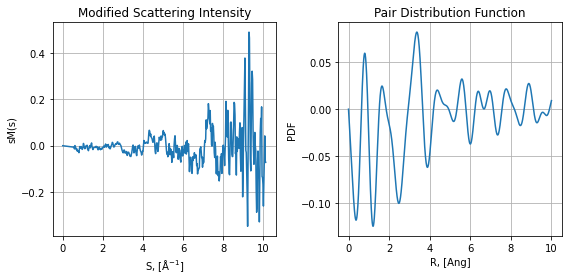

In [185]:

plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s_3,sM[10]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');plt.title('Modified Scattering Intensity');plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r,pdf_exp[30]);
plt.xlabel(r'R, [Ang]');
plt.ylabel('PDF');
plt.title('Pair Distribution Function');
plt.grid()
    
plt.tight_layout()
plt.show()

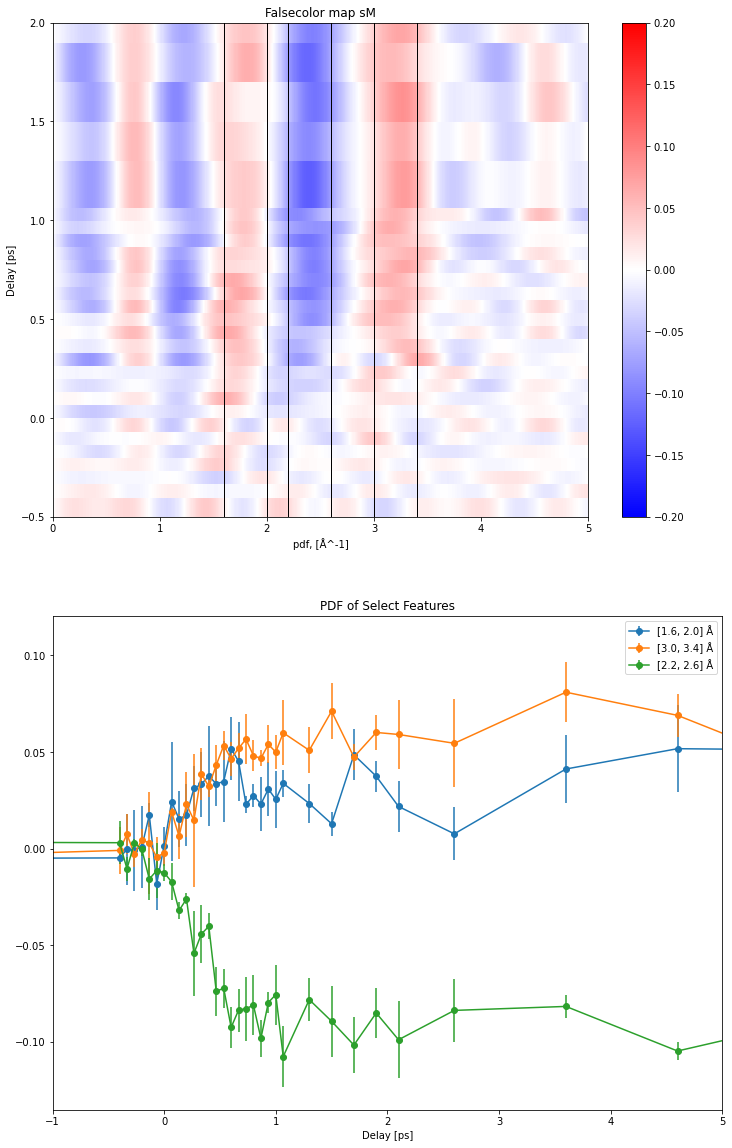

In [186]:
RoI_1 = [1.6, 2.0];
RoI_2 = [3.0, 3.4];
RoI_3 = [2.2, 2.6];

Inte_1 = np.mean(pdf_exp[:, (np.where((r > RoI_1[0]) & (r < RoI_1[1]))[0])], axis=1)
std_1 = np.std(pdf_exp[:, (np.where((r > RoI_1[0]) & (r < RoI_1[1]))[0])], axis=1)
Inte_2 = np.mean(pdf_exp[:, (np.where((r > RoI_2[0]) & (r < RoI_2[1]))[0])], axis=1)
std_2 = np.std(pdf_exp[:, (np.where((r > RoI_2[0]) & (r < RoI_2[1]))[0])], axis=1)
Inte_3 = np.mean(pdf_exp[:, (np.where((r > RoI_3[0]) & (r < RoI_3[1]))[0])], axis=1)
std_3 = np.std(pdf_exp[:, (np.where((r > RoI_3[0]) & (r < RoI_3[1]))[0])], axis=1)

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(r, t_2, pdf_exp,cmap='bwr')
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1)

plt.clim(vmin=-0.2, vmax=0.2);
plt.colorbar()
plt.ylim(-0.5, 2.0)
plt.xlim(0, 5)
plt.xlabel(f"pdf, [{angs}^-1]")
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map sM')

plt.subplot(2,1,2)
plt.errorbar(t_2,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(t_2, Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.errorbar(t_2, Inte_3, yerr = std_3, fmt='-o', label=str(RoI_3)+' '+angs)
plt.xlim(-1, 5)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('PDF of Select Features')

plt.show()

## T0 Fitting

Fit parameters: 
t_0 = 0.4642  ps +-  0.0375  ps
FWHM =  0.2921 ps 0.1211 ps




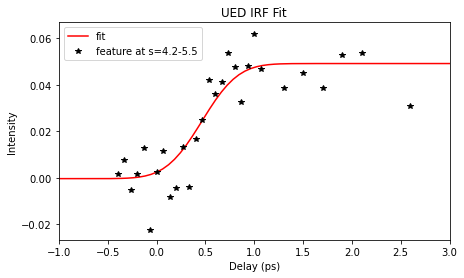

In [163]:
data_1= Inte_2-Inte_3+Inte_1


A = 0.03
t0 = 0.5
sigma = 0.5
offset = 0.1
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, info, _, _ = curve_fit(erf_fit, t_2[:], data_1[:], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(t_2[0],t_2[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(t_2, data_1,'*',color='black', label="feature at s=4.2-5.5")
plt.xlim(-1,3)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()